# This notebook is to explore the possibility of using fast embedding method to embed the whole mouse PFC network

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import os
import networkx as nx
from sys import platform 
from src.embedding.network_embedding import *
from src.eda.eda_functions import (plot_gene_cnt_each_cluster, get_closest_genes_jaccard, cluster_nmi_v3,
                                   cluster_jaccard_v2, run_kmeans, cluster_DE_perc, plot_cluster_nmi_comparison_v3)

import time
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def network_embedding_fast(edgelist_data, max_epoch = 100, learning_rate = 0.1, negative_ratio = 0.15, tol_samples = 75, output_dir = None, name_spec = ''):
    '''
    edgelist_path: path to the edgelist for embedding
    name_spec: any additional info as str to add for saving the embedding df
    '''
    G = cg.read_edgelist(edgelist_data, directed = False, sep = '\t')
    ggvec_model = nodevectors.GGVec(n_components = 64, max_epoch = max_epoch, learning_rate = learning_rate, 
                                    negative_ratio = negative_ratio, tol_samples = tol_samples) 
    embeddings = ggvec_model.fit_transform(G)
    emb_df = pd.DataFrame(embeddings, index = ggvec_model.model.keys())
    if output_dir:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        emb_df.to_csv(f'{output_dir}/embedded_ggvec_{name_spec}.csv')
        print('embedding data saved')
    return emb_df

In [3]:
# convert df from adjacency to edgelist
def mouse_adj_to_edgelist(adj_df, filename = None, output_dir = None):
    adj_df_copy = adj_df.copy()
    adj_df_copy.values[tuple([np.arange(len(adj_df_copy))]*2)] = np.nan
    edge_df = adj_df_copy.stack().reset_index()
#     edge_df['level_0'] = list(map(lambda x:int(x.split('_')[1]), edge_df['level_0']))
#     edge_df['level_1'] = list(map(lambda x:int(x.split('_')[1]), edge_df['level_1']))
    if output_dir != None:
        assert filename != None, 'Need the filename for saving'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        edge_df.to_csv(f'{output_dir}/{filename}_edge.txt', sep = '\t', index = 0, header = None)
        print(f'{filename}_edge.txt has been saved.')
    return edge_df

In [25]:
mouse_tom = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/pipeline/mouse/network_analysis/tom.csv', index_col = 0)

In [88]:
%%time
edge_df = mouse_adj_to_edgelist(mouse_tom, 'PFC', output_dir = prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived')

PFC_edge.txt has been saved.
Wall time: 12min 48s


In [7]:
embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Feb14'
alpha = 0.2
epoch = 300
n_samples = 20    
t1 = time.time()
emb_df = network_embedding_fast(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/PFC_edge.txt', 
                                      max_epoch = epoch ,learning_rate = alpha, negative_ratio = 0.1,
                                      output_dir = embedding_path, name_spec = f'PFC_epoch={epoch}_alpha={alpha}_tol_samples={n_samples}')
t2 = time.time()
print(f'embedding for epoch={epoch}_alpha={alpha}_tol_samples={n_samples} took {t2-t1}')

embedding data saved
embedding for epoch=300_alpha=0.2_tol_samples=20 took 7611.773996591568


In [ ]:
# embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Feb14'

# for epoch, alpha in zip([100,100,200],[0.1,0.2,0.2]):
#     for alpha in [0.1,0.2]:
#         t1 = time.time()
#         emb_df = network_embedding_fast(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/PFC_edge.txt', 
#                                               max_epoch = epoch ,learning_rate = alpha, 
#                                               output_dir = embedding_path, name_spec = f'PFC_epoch={epoch}_alpha={alpha}')
#         t2 = time.time()
#         print(f'embedding for epoch={epoch}_alpha={alpha} took {t2-t1}')

In [5]:
embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Feb14'
emb_list = []
emb_names = []
kmeans_list = []
for file in os.listdir(embedding_path)[1:]:
    emb = pd.read_csv(os.path.join(embedding_path, file), index_col = 0)
    emb_list.append(emb)
    emb_names.append(file.split('ggvec_')[1][:-4])
    kmeans_list.append(run_kmeans(emb, 8))

In [4]:
embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Feb14'
emb_df = pd.read_csv(os.path.join(embedding_path, 'mouse_embedded_ggvec_PFC_epoch=100_alpha=0.1.csv'), index_col = 0)
kmeans = run_kmeans(emb_df, 8)

In [18]:
de_data = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv')
de_data['abs_log2FC'] = abs(de_data['log2FoldChange'])

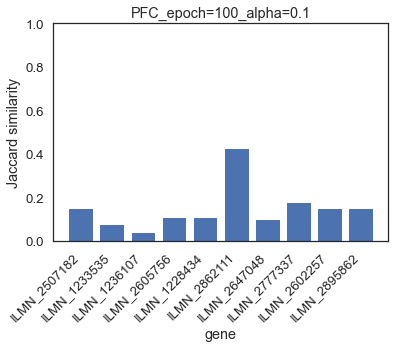

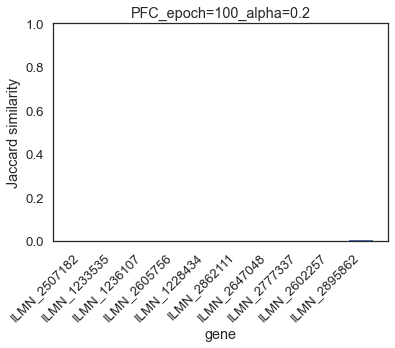

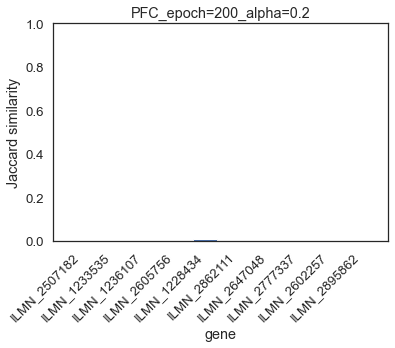

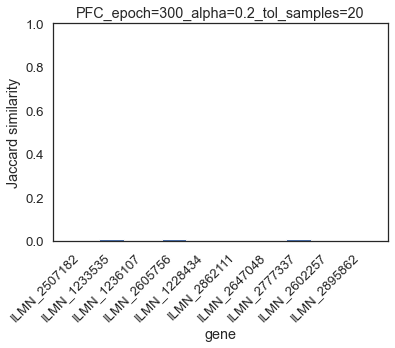

In [34]:
top_n_de = de_data.sort_values('abs_log2FC', ascending = False)['id'][:10]
for emb, name in zip(emb_list, emb_names):
    get_closest_genes_jaccard(mouse_tom, emb, top_n_de, 50, name)

In [6]:
pfc_wgcna = pd.read_csv(prefix+'/Shared drives/NIAAA_ASSIST/Data/pipeline/mouse/network_analysis/wgcna_modules.csv')

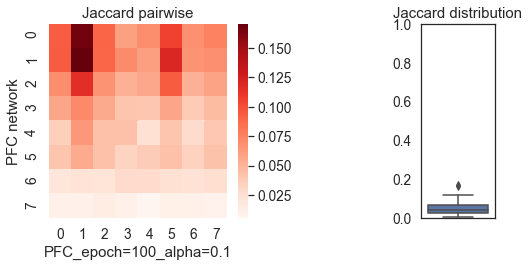

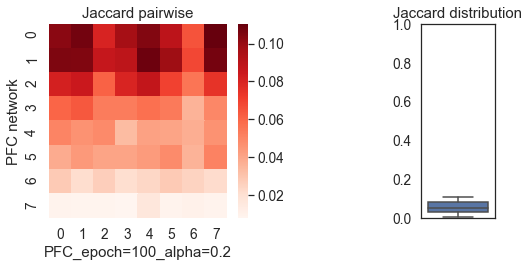

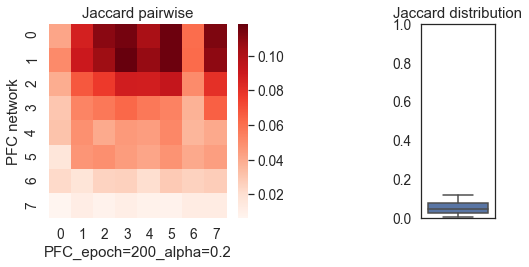

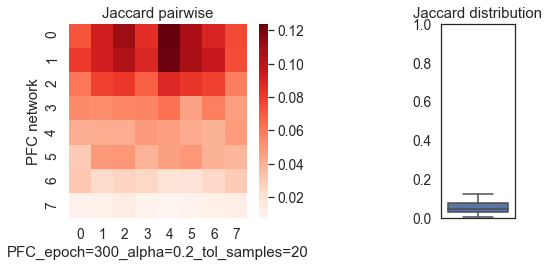

In [35]:
for kmeans, name in zip(kmeans_list, emb_names):
    cluster_jaccard_v2(pfc_wgcna, kmeans, 'louvain_label', 'kmean_label', ['PFC network', name])

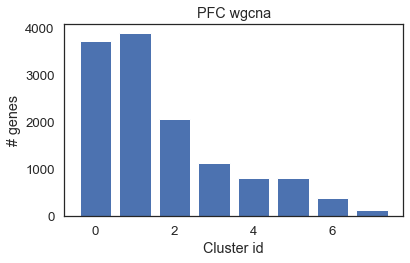

In [40]:
plot_gene_cnt_each_cluster([pfc_wgcna], 'louvain_label', ['PFC wgcna'])

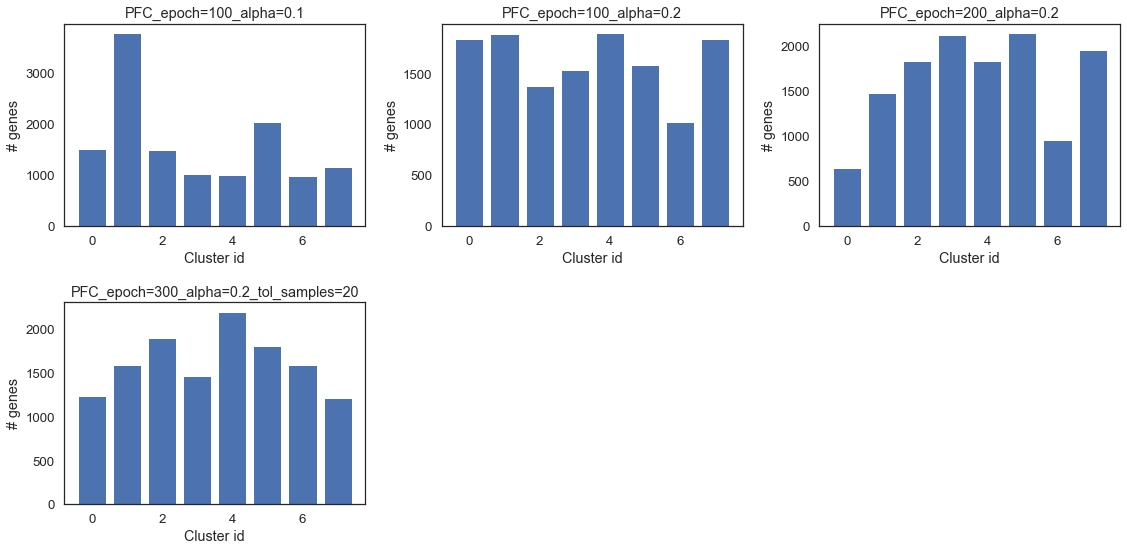

In [39]:
plot_gene_cnt_each_cluster(kmeans_list, 'kmean_label', emb_names)

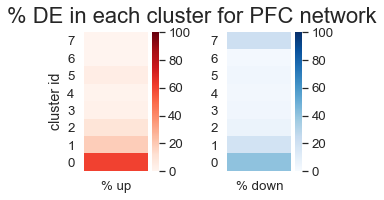

In [20]:
cluster_DE_perc(pfc_wgcna, 'louvain_label', 'PFC network', de_data)

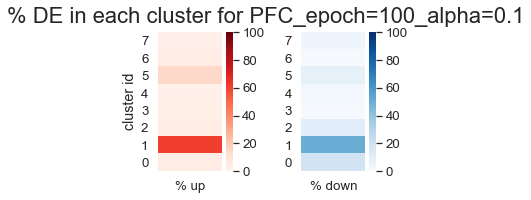

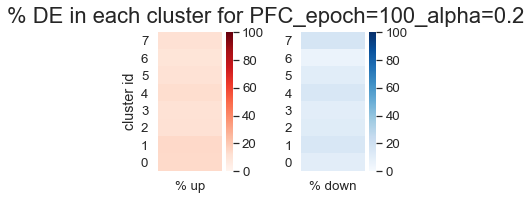

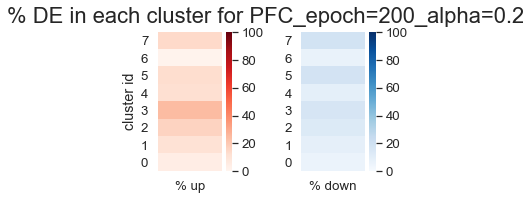

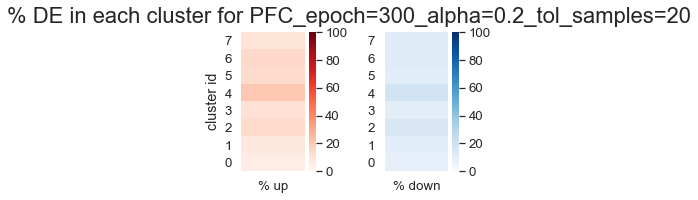

In [36]:
for kmeans, name in zip(kmeans_list, emb_names):
    cluster_DE_perc(kmeans, 'kmean_label', name, de_data)

In [7]:
print('NMI between network modules and embedding clusters is')
cluster_nmi_v3(pfc_wgcna, 'louvain_label', kmeans, 'kmean_label')

NMI between network modules and embedding clusters is


0.5747945730438245

Removing existing folder: output
Created folder output


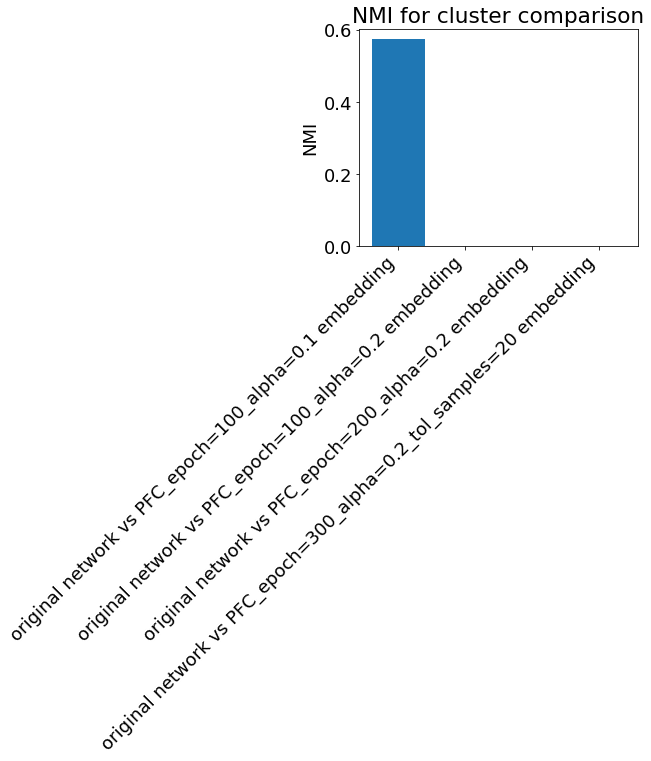

In [11]:
# for kmeans, name in zip(kmeans_list, emb_names):
network_comparison_names = ['original network' + f' vs {emb_names[i]} embedding' for i in range(len(emb_names))]
plot_cluster_nmi_comparison_v3('network', cluster1 = pfc_wgcna, cluster1_column = 'louvain_label', 
                               cluster2_list= kmeans_list, cluster2_column = 'kmean_label', comparison_names = network_comparison_names)